<a href="https://colab.research.google.com/github/singhvertika119/Learning-DL-Pytorch/blob/main/imageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from google.colab import files

In [4]:
# convert images to tensors and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)) # normalize RGB
])

In [5]:
# load CIFAR-10 train and test dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


In [6]:
# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

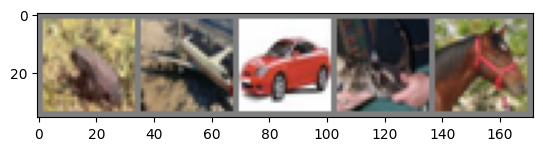

frog plane car cat horse


In [7]:
# function to show an image
def imshow(img):
  img = img / 2 + 0.5   # unnormalize since we normalized earlier
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))  # CHW -> HWC
  plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]}' for j in range(5)))

In [8]:
# neural network
class CIFAR10_CNN(nn.Module):
  def __init__(self):
    super(CIFAR10_CNN, self).__init__()
    # 1st conv block
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    # 2nd conv block
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    # 3rd conv block
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(128)

    # dropout layer helps prevent overfitting
    self.dropout = nn.Dropout(0.5)
    # fully connected layers
    self.fc1 = nn.Linear(128*4*4, 256)
    self.bn_fc1 = nn.BatchNorm1d(256)
    self.fc2 = nn.Linear(256, 10)
    # max pooling
    self.pool = nn.MaxPool2d(2, 2)

  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x)))) # -> (32, 16, 16)
    x = self.pool(F.relu(self.bn2(self.conv2(x)))) # -> (64, 8, 8)
    x = self.pool(F.relu(self.bn3(self.conv3(x)))) # -> (128, 4, 4)
    # flatten
    x = x.view(-1, 128 * 4 * 4)
    # Fully connected with dropout
    x = F.relu(self.bn_fc1(self.fc1(x)))
    x = self.dropout(x)  # randomly zeroes 50% of activations

    # Output
    x = self.fc2(x)
    return x

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)

using device: cuda


In [10]:
# initialize mode
model = CIFAR10_CNN().to(device)

In [11]:
# loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [12]:
# training the model
num_epochs = 20
for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0
  correct = 0
  total = 0

  for images, labels in trainloader:
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

  train_acc = 100. * correct/total
  train_loss /= len(trainloader)

  # Validation
  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in testloader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

  val_acc = 100. * correct/total
  val_loss /= len(testloader)

  scheduler.step()
  print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch [1/20] Train Loss: 1.5093, Train Acc: 46.64% | Val Loss: 0.9912, Val Acc: 65.50%
Epoch [2/20] Train Loss: 1.2127, Train Acc: 58.10% | Val Loss: 0.8445, Val Acc: 71.18%
Epoch [3/20] Train Loss: 1.0968, Train Acc: 62.95% | Val Loss: 0.7917, Val Acc: 73.73%
Epoch [4/20] Train Loss: 1.0110, Train Acc: 66.05% | Val Loss: 0.7524, Val Acc: 75.35%
Epoch [5/20] Train Loss: 0.9469, Train Acc: 68.32% | Val Loss: 0.6930, Val Acc: 76.97%
Epoch [6/20] Train Loss: 0.8833, Train Acc: 70.62% | Val Loss: 0.6815, Val Acc: 77.09%
Epoch [7/20] Train Loss: 0.8446, Train Acc: 71.74% | Val Loss: 0.6565, Val Acc: 77.77%
Epoch [8/20] Train Loss: 0.8070, Train Acc: 73.17% | Val Loss: 0.6481, Val Acc: 78.06%
Epoch [9/20] Train Loss: 0.7713, Train Acc: 74.29% | Val Loss: 0.6280, Val Acc: 78.80%
Epoch [10/20] Train Loss: 0.7354, Train Acc: 75.43% | Val Loss: 0.6160, Val Acc: 78.78%
Epoch [11/20] Train Loss: 0.6521, Train Acc: 78.34% | Val Loss: 0.6034, Val Acc: 79.59%
Epoch [12/20] Train Loss: 0.6173, Train A

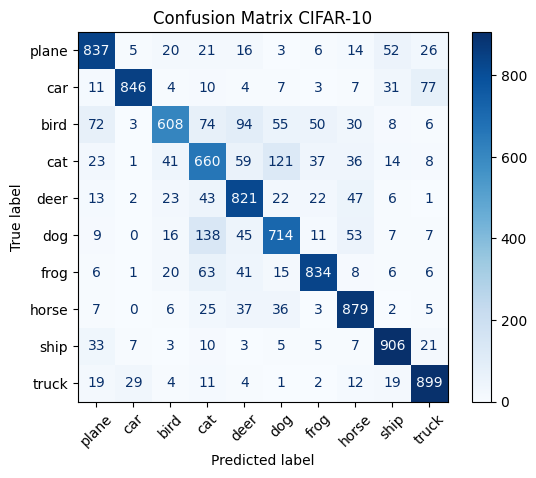


Class-wise Accuracy:
plane: 83.70%
car: 84.60%
bird: 60.80%
cat: 66.00%
deer: 82.10%
dog: 71.40%
frog: 83.40%
horse: 87.90%
ship: 90.60%
truck: 89.90%


In [13]:
# model evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
  for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    outputs  = model(images)
    _, predicted = outputs.max(1)
    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix CIFAR-10")
plt.show()

# class wise accuracy
class_correct = np.diag(cm)
class_total = np.sum(cm, axis=1)
class_acc = class_correct / class_total

print("\nClass-wise Accuracy:")
for i, acc in enumerate(class_acc):
  print(f"{classes[i]}: {acc*100:.2f}%")

In [14]:
# data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [15]:
# non augmented test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [16]:
# Reload datasets with new transforms
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                           shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                          shuffle=False, num_workers=2)

In [17]:
# Upload an image
uploaded = files.upload()

# Get the uploaded image path
for fn in uploaded.keys():
    img_path = fn
    print("Uploaded file:", img_path)

Saving dog.jpg to dog.jpg
Uploaded file: dog.jpg


In [18]:
# preprocessing of image
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # CIFAR-10 images are 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))  # CIFAR-10 mean/std
])

Original Uploaded Image


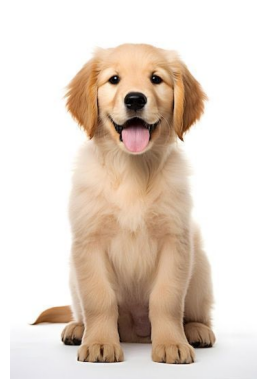

In [19]:
print("Original Uploaded Image")
img = Image.open(img_path)
plt.imshow(img)
plt.axis("off")
plt.show()

In [20]:
def predict_image(image_path, model):
  img = Image.open(image_path).convert('RGB')
  img = transform(img).unsqueeze(0).to(device)

  model.eval()
  with torch.no_grad():
    outputs = model(img)
    _, predicted = outputs.max(1)

  class_name = classes[predicted.item()]
  print(f"Predicted Class: {class_name}")
  return class_name

In [21]:
# Example: upload an image of cat/dog/etc. before running this
pred_class = predict_image(img_path, model)


Predicted Class: dog
